In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# === INSTALLATION ===
!pip install pydicom nibabel nilearn scikit-image --quiet

## Étapes de prétraitement

In [98]:
# === CELLULE 1: IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Imports pour l'imagerie médicale
import nibabel as nib
import pydicom
from nilearn import plotting
from scipy import ndimage
from PIL import Image

# Imports pour le ML
from sklearn.model_selection import train_test_split
import joblib

print("✅ Toutes les librairies sont installées et importées")

✅ Toutes les librairies sont installées et importées


In [99]:
# === CELLULE 2: CONFIGURATION ET CHEMINS ===
# Configuration globale
class Config:
    BASE_PATH = "/kaggle/input/parkinsons-disease-fmri-images/Disease_Prediction-20231213T083430Z-001/Disease_Prediction"
    PARKINSON_PATH = os.path.join(BASE_PATH, "PD_new")
    HEALTHY_PATH = os.path.join(BASE_PATH, "HC_new")
    SAVE_PATH = "/kaggle/working/processed_data/"
    
    # Paramètres de prétraitement
    TARGET_SIZE = (224, 224)
    CONVERT_TO_RGB = False
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    RANDOM_STATE = 42
    
    # Paramètres d'augmentation
    AUGMENTATION_FACTOR = 2
    ELASTIC_ALPHA = (50, 150)
    ELASTIC_SIGMA = (5, 10)

config = Config()

# Création du dossier de sauvegarde
os.makedirs(config.SAVE_PATH, exist_ok=True)
print("✅ Configuration initialisée")

✅ Configuration initialisée


In [100]:
# === CELLULE 2B: SAUVEGARDE DE LA CONFIGURATION EN JSON ===
import json

config_dict = {attr: getattr(config, attr) for attr in dir(config) if not attr.startswith("__") and not callable(getattr(config, attr))}
os.makedirs(config.SAVE_PATH, exist_ok=True)
with open(os.path.join(config.SAVE_PATH, "config.json"), "w") as f:
    json.dump(config_dict, f, indent=4)

print(f"✅ Configuration sauvegardée dans: {os.path.join(config.SAVE_PATH, 'config.json')}")

✅ Configuration sauvegardée dans: /kaggle/working/processed_data/config.json


In [101]:
# === CELLULE 3: ANALYSE EXPLORATOIRE DU DATASET ===
def analyze_dataset_structure():
    """Analyse complète de la structure du dataset"""
    print("=== ANALYSE EXPLORATOIRE DU DATASET ===\n")
    
    results = {}
    
    for path, label in [(config.PARKINSON_PATH, "Parkinson"), (config.HEALTHY_PATH, "Healthy")]:
        print(f"--- {label} ---")
        
        if not os.path.exists(path):
            print(f"❌ Chemin non trouvé: {path}")
            continue
            
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        print(f"Nombre total de fichiers: {len(files)}")
        
        # Analyse des extensions
        extensions = Counter([f.split('.')[-1].lower() for f in files])
        print(f"Répartition des formats: {dict(extensions)}")
        
        # Analyse de la taille des fichiers
        sizes = []
        valid_files = []
        
        for file in files[:5]:  # Sample des 5 premiers fichiers
            file_path = os.path.join(path, file)
            size_kb = os.path.getsize(file_path) // 1024
            sizes.append(size_kb)
            valid_files.append(file)
            print(f"  {file}: {size_kb} KB")
        
        results[label] = {
            'total_files': len(files),
            'extensions': dict(extensions),
            'sample_files': valid_files,
            'avg_size_kb': np.mean(sizes) if sizes else 0
        }
        print()
    
    return results

# Exécution de l'analyse
dataset_analysis = analyze_dataset_structure()

=== ANALYSE EXPLORATOIRE DU DATASET ===

--- Parkinson ---
Nombre total de fichiers: 290
Répartition des formats: {'dcm': 75, 'jpg': 210, 'png': 5}
  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103757194_33_S180778_I355962.dcm: 517 KB
  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103755493_180_S180778_I355962.jpg: 20 KB
  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103802685_151_S180778_I355962.jpg: 22 KB
  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103642601_99_S180778_I355962.jpg: 22 KB
  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103815585_59_S180778_I355962.jpg: 25 KB

--- Healthy ---
Nombre total de fichiers: 26
Répartition des formats: {'jpg': 14, 'png': 12}
  PPMI_103542_MR_rsfMRI_LR__br_raw_20220106125334433_3_S1093544_I1530517.jpg: 19 KB
  download - 2021-06-10T140521.421.png: 109 KB
  PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171453607_75_S1161815_I1624166.jpg: 23 KB
  download - 2021-06-10T140528.184.png: 109 KB
  download - 2021-06-10T140511.565.png: 108 KB


In [102]:
# === CELLULE 4: INSPECTION DES FORMATS DE FICHIERS ===
def inspect_file_formats():
    """Inspection détaillée des formats de fichiers"""
    print("=== INSPECTION DES FORMATS DE FICHIERS ===\n")
    
    file_info = []
    
    for path, label in [(config.PARKINSON_PATH, "Parkinson"), (config.HEALTHY_PATH, "Healthy")]:
        files = os.listdir(path)
        
        for file in files[:3]:  # Inspecter les 3 premiers fichiers de chaque classe
            file_path = os.path.join(path, file)
            info = {'label': label, 'file': file, 'extension': file.split('.')[-1].lower()}
            
            try:
                if file.endswith(('.nii', '.nii.gz')):
                    img = nib.load(file_path)
                    info.update({
                        'type': 'NIfTI',
                        'shape': img.shape,
                        'dimensions': len(img.shape),
                        'data_type': img.get_data_dtype()
                    })
                    
                elif file.endswith('.dcm'):
                    ds = pydicom.dcmread(file_path, force=True)
                    info.update({
                        'type': 'DICOM',
                        'shape': ds.pixel_array.shape,
                        'dimensions': len(ds.pixel_array.shape),
                        'modality': getattr(ds, 'Modality', 'N/A')
                    })
                    
                elif file.endswith(('.jpg', '.png', '.jpeg')):
                    img = Image.open(file_path)
                    info.update({
                        'type': 'Image',
                        'shape': img.size,
                        'dimensions': 2,
                        'mode': img.mode
                    })
                    
                else:
                    info['type'] = 'Autre'
                    
            except Exception as e:
                info['error'] = str(e)
                info['type'] = 'Erreur'
            
            file_info.append(info)
    
    # Création d'un DataFrame pour analyse
    df_info = pd.DataFrame(file_info)
    print(df_info.to_string(index=False))
    
    return df_info

# Exécution de l'inspection
file_formats_info = inspect_file_formats()

=== INSPECTION DES FORMATS DE FICHIERS ===

    label                                                                             file extension  type      shape  dimensions modality mode
Parkinson  PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103757194_33_S180778_I355962.dcm       dcm DICOM (462, 476)           2       MR  NaN
Parkinson PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103755493_180_S180778_I355962.jpg       jpg Image (476, 462)           2      NaN    L
Parkinson PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103802685_151_S180778_I355962.jpg       jpg Image (476, 462)           2      NaN    L
  Healthy       PPMI_103542_MR_rsfMRI_LR__br_raw_20220106125334433_3_S1093544_I1530517.jpg       jpg Image (448, 448)           2      NaN    L
  Healthy                                             download - 2021-06-10T140521.421.png       png Image (512, 512)           2      NaN RGBA
  Healthy      PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171453607_75_S1161815_I1624166.jpg  

In [103]:
# === CELLULE 5: CHARGEMENT ET PRÉTRAITEMENT UNIFIÉ ===
def load_and_preprocess_data():
    """Chargement et prétraitement unifié des données"""
    print("=== CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES ===\n")
    
    X = []
    y = []
    patient_info = []
    
    def process_single_file(file_path, label, file_name):
        """Traiter un fichier individuel"""
        try:
            if file_name.lower().endswith(('.nii', '.nii.gz')):
                # Chargement NIfTI
                img = nib.load(file_path)
                data = img.get_fdata()
                
                # Gestion des dimensions
                if len(data.shape) == 4:  # fMRI 4D
                    data = data.mean(axis=3)  # Moyenne temporelle
                elif len(data.shape) == 3:  # 3D
                    data = data[:, :, data.shape[2]//2]  # Coupe centrale
                
            elif file_name.lower().endswith('.dcm'):
                # Chargement DICOM
                ds = pydicom.dcmread(file_path)
                data = ds.pixel_array.astype(np.float32)
                
            elif file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                # Chargement image standard
                img = Image.open(file_path).convert('L')  #Conversion en niveaux de gris
                data = np.array(img, dtype=np.float32)
                
            else:
                return None
                
            # Vérifications de qualité
            if (np.isnan(data).any() or np.max(data) == 0 or 
                np.min(data) == np.max(data)):
                return None
            
            # Normalisation [0, 1]
            data_norm = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
            
            return data_norm
            
        except Exception as e:
            print(f"❌ Erreur avec {file_name}: {e}")
            return None
    
    # Traitement des fichiers Parkinson
    print("Chargement des données Parkinson...")
    parkinson_files = [f for f in os.listdir(config.PARKINSON_PATH) 
                      if os.path.isfile(os.path.join(config.PARKINSON_PATH, f))]
    
    for file_name in tqdm(parkinson_files, desc="Parkinson"):
        file_path = os.path.join(config.PARKINSON_PATH, file_name)
        processed_data = process_single_file(file_path, "Parkinson", file_name)
        
        if processed_data is not None:
            X.append(processed_data)
            y.append(1)  # Label Parkinson
            patient_info.append({
                'file_name': file_name,
                'group': 'Parkinson',
                'original_shape': processed_data.shape
            })
    
    # Traitement des fichiers Healthy
    print("Chargement des données Healthy...")
    healthy_files = [f for f in os.listdir(config.HEALTHY_PATH) 
                    if os.path.isfile(os.path.join(config.HEALTHY_PATH, f))]
    
    for file_name in tqdm(healthy_files, desc="Healthy"):
        file_path = os.path.join(config.HEALTHY_PATH, file_name)
        processed_data = process_single_file(file_path, "Healthy", file_name)
        
        if processed_data is not None:
            X.append(processed_data)
            y.append(0)  # Label Healthy
            patient_info.append({
                'file_name': file_name,
                'group': 'Healthy',
                'original_shape': processed_data.shape
            })
    
    print(f"\n✅ Chargement terminé: {len(X)} fichiers traités avec succès")
    print(f"📊 Répartition: Parkinson={sum(y)}, Healthy={len(y)-sum(y)}")
    
    return X, y, patient_info

# Exécution du chargement
X, y, patient_info = load_and_preprocess_data()

=== CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES ===

Chargement des données Parkinson...


Parkinson: 100%|██████████| 290/290 [00:01<00:00, 246.87it/s]


Chargement des données Healthy...


Healthy: 100%|██████████| 26/26 [00:00<00:00, 159.44it/s]


✅ Chargement terminé: 316 fichiers traités avec succès
📊 Répartition: Parkinson=290, Healthy=26


In [104]:
# === CELLULE 6: VÉRIFICATION DE LA QUALITÉ DES DONNÉES ===
def comprehensive_quality_check(X, y, patient_info):
    """Vérification complète de la qualité des données"""
    print("=== VÉRIFICATION DE LA QUALITÉ DES DONNÉES ===\n")
    
    # Calcul du déséquilibre
    parkinson_count = sum(y)
    healthy_count = len(y) - parkinson_count
    imbalance_ratio = parkinson_count / healthy_count if healthy_count > 0 else float('inf')
    
    checks = {
        'samples_count': len(X) >= 50,
        'class_balance': imbalance_ratio < 5,  # Ratio max 5:1 (plus réaliste que 0.8)
        'normalization': all(0 <= np.min(x) <= 1 and 0 <= np.max(x) <= 1 for x in X[:10]),
        'no_nan_inf': not any(np.isnan(x).any() or np.isinf(x).any() for x in X),
        'consistent_shapes': len(set(x.shape for x in X)) <= 3
    }
    
    # Affichage des résultats
    for check_name, check_result in checks.items():
        status = "✅" if check_result else "❌"
        print(f"{status} {check_name}: {check_result}")
    
    # Statistiques détaillées
    print(f"\n📊 STATISTIQUES DÉTAILLÉES:")
    print(f"   Total échantillons: {len(X)}")
    print(f"   Parkinson: {parkinson_count} ({parkinson_count/len(y)*100:.1f}%)")
    print(f"   Healthy: {healthy_count} ({healthy_count/len(y)*100:.1f}%)")
    print(f"   Ratio de déséquilibre: {imbalance_ratio:.1f}:1")
    
    shapes = Counter([x.shape for x in X])
    print(f"   Dimensions: {dict(shapes)}")
    
    # Vérification de la normalisation
    means = [np.mean(x) for x in X]
    stds = [np.std(x) for x in X]
    print(f"   Normalisation - Moyenne: {np.mean(means):.3f} ± {np.std(means):.3f}")
    print(f"   Normalisation - Écart-type: {np.mean(stds):.3f} ± {np.std(stds):.3f}")
    
    # 🔥 ANALYSE CRITIQUE DU DÉSÉQUILIBRE
    print(f"\n🚨 ANALYSE DU DÉSÉQUILIBRE DES CLASSES:")
    print(f"   • Ratio actuel: {imbalance_ratio:.1f}:1 (Parkinson:Healthy)")
    print(f"   • Niveau de sévérité: {'CRITIQUE' if imbalance_ratio > 10 else 'ÉLEVÉ' if imbalance_ratio > 5 else 'MODÉRÉ'}")
    
    if imbalance_ratio > 3:
        print(f"\n💡 RECOMMANDATIONS POUR CORRIGER LE DÉSÉQUILIBRE:")
        print(f"   1. Augmentation agressive (facteur {min(8, int(imbalance_ratio))}x pour la classe minoritaire)")
        print(f"   2. Utilisation de techniques de ré-échantillonnage (SMOTE, ADASYN)")
        print(f"   3. Poids de classe dans la fonction de perte")
        print(f"   4. Métriques adaptées (F1-score, AUC-ROC au lieu de l'accuracy)")
    
    return checks

# Exécution de la vérification
quality_checks = comprehensive_quality_check(X, y, patient_info)

# Déterminer si on peut continuer malgré le déséquilibre
can_proceed = (quality_checks['samples_count'] and 
               quality_checks['normalization'] and 
               quality_checks['no_nan_inf'])

print(f"\n🎯 DÉCISION: {'✅ PEUT CONTINUER' if can_proceed else '❌ DOIT CORRIGER LE DÉSÉQUILIBRE'}")
print(f"   Le déséquilibre sera traité dans la phase d'augmentation")

=== VÉRIFICATION DE LA QUALITÉ DES DONNÉES ===

✅ samples_count: True
❌ class_balance: False
✅ normalization: True
✅ no_nan_inf: True
✅ consistent_shapes: True

📊 STATISTIQUES DÉTAILLÉES:
   Total échantillons: 316
   Parkinson: 290 (91.8%)
   Healthy: 26 (8.2%)
   Ratio de déséquilibre: 11.2:1
   Dimensions: {(462, 476): 285, (512, 512): 17, (448, 448): 14}
   Normalisation - Moyenne: 0.090 ± 0.012
   Normalisation - Écart-type: 0.158 ± 0.018

🚨 ANALYSE DU DÉSÉQUILIBRE DES CLASSES:
   • Ratio actuel: 11.2:1 (Parkinson:Healthy)
   • Niveau de sévérité: CRITIQUE

💡 RECOMMANDATIONS POUR CORRIGER LE DÉSÉQUILIBRE:
   1. Augmentation agressive (facteur 8x pour la classe minoritaire)
   2. Utilisation de techniques de ré-échantillonnage (SMOTE, ADASYN)
   3. Poids de classe dans la fonction de perte
   4. Métriques adaptées (F1-score, AUC-ROC au lieu de l'accuracy)

🎯 DÉCISION: ✅ PEUT CONTINUER
   Le déséquilibre sera traité dans la phase d'augmentation


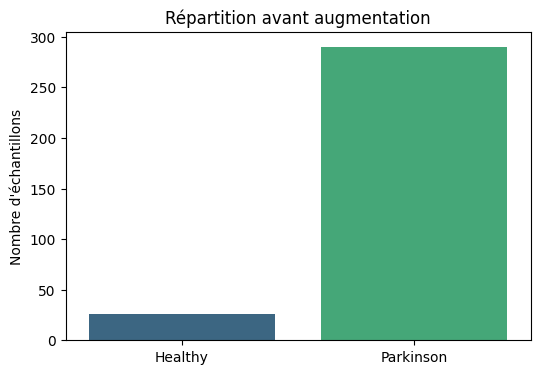

In [129]:
# === CELLULE 7: VISUALISATION DU DÉSÉQUILIBRE DES CLASSES ===
def plot_class_distribution(y, title="Répartition des classes"):
    """Affichage du déséquilibre des classes"""
    counts = Counter(y)
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.xticks([0,1], ["Healthy", "Parkinson"])
    plt.ylabel("Nombre d'échantillons")
    plt.title(title)
    plt.show()

# Visualisation SEULEMENT avant augmentation
plot_class_distribution(y, "Répartition avant augmentation")

In [130]:
# === CELLULE 8: MÉTRIQUES POUR DONNÉES DÉSÉQUILIBRÉES ===
def display_imbalance_metrics(y):
    """Afficher les métriques adaptées aux données déséquilibrées"""
    print("=== MÉTRIQUES ADAPTÉES AU DÉSÉQUILIBRE ===\n")
    
    # Analyse du déséquilibre actuel
    parkinson_count = sum(y)
    healthy_count = len(y) - parkinson_count
    imbalance_ratio = parkinson_count / healthy_count if healthy_count > 0 else float('inf')
    
    print(f"📊 ANALYSE DU DÉSÉQUILIBRE ACTUEL:")
    print(f"   • Parkinson: {parkinson_count} échantillons")
    print(f"   • Healthy: {healthy_count} échantillons") 
    print(f"   • Ratio: {imbalance_ratio:.1f}:1")
    print(f"   • Pourcentage: Parkinson {parkinson_count/len(y)*100:.1f}% vs Healthy {healthy_count/len(y)*100:.1f}%")
    
    print(f"\n🎯 DANS LE PIRE SCÉNARIO (tout prédire Parkinson):")
    print(f"   • Accuracy: {parkinson_count/len(y)*100:.1f}%")
    print(f"   • Rappel Healthy: 0%")
    print(f"   • F1-score Healthy: 0%")
    print(f"   → Modèle inutile malgré une accuracy élevée!")
    
    print(f"\n💡 MÉTRIQUES PRIVILÉGIÉES POUR L'ÉVALUATION:")
    print(f"   1. 🔥 F1-score par classe (surtout Healthy)")
    print(f"   2. 🔥 Matrice de confusion")
    print(f"   3. 🔥 Rapport de classification détaillé")
    print(f"   4. 📈 Courbe ROC et AUC")
    print(f"   5. 📈 Courbe Precision-Recall")
    print(f"   6. 📊 Balanced Accuracy")
    
    print(f"\n🎯 OBJECTIFS DE PERFORMANCE POUR LE MODÈLE:")
    print(f"   • F1-score Healthy > 70%")
    print(f"   • AUC-ROC > 80%") 
    print(f"   • Rappel Healthy > 60%")
    print(f"   • Précision Healthy > 65%")
    
    print(f"\n🛠️ TECHNIQUES POUR AMÉLIORER LES PERFORMANCES:")
    print(f"   • Augmentation de données agressive")
    print(f"   • Poids de classe dans la loss function")
    print(f"   • Ré-échantillonnage (oversampling/undersampling)")
    print(f"   • Utilisation de Focal Loss")
    print(f"   • Validation croisée stratifiée")

# Exécution de l'analyse des métriques
display_imbalance_metrics(y)

=== MÉTRIQUES ADAPTÉES AU DÉSÉQUILIBRE ===

📊 ANALYSE DU DÉSÉQUILIBRE ACTUEL:
   • Parkinson: 290 échantillons
   • Healthy: 26 échantillons
   • Ratio: 11.2:1
   • Pourcentage: Parkinson 91.8% vs Healthy 8.2%

🎯 DANS LE PIRE SCÉNARIO (tout prédire Parkinson):
   • Accuracy: 91.8%
   • Rappel Healthy: 0%
   • F1-score Healthy: 0%
   → Modèle inutile malgré une accuracy élevée!

💡 MÉTRIQUES PRIVILÉGIÉES POUR L'ÉVALUATION:
   1. 🔥 F1-score par classe (surtout Healthy)
   2. 🔥 Matrice de confusion
   3. 🔥 Rapport de classification détaillé
   4. 📈 Courbe ROC et AUC
   5. 📈 Courbe Precision-Recall
   6. 📊 Balanced Accuracy

🎯 OBJECTIFS DE PERFORMANCE POUR LE MODÈLE:
   • F1-score Healthy > 70%
   • AUC-ROC > 80%
   • Rappel Healthy > 60%
   • Précision Healthy > 65%

🛠️ TECHNIQUES POUR AMÉLIORER LES PERFORMANCES:
   • Augmentation de données agressive
   • Poids de classe dans la loss function
   • Ré-échantillonnage (oversampling/undersampling)
   • Utilisation de Focal Loss
   • Validati

In [131]:
# === CELLULE 9: UNIFORMISATION DES DIMENSIONS ===
def standardize_dimensions(X, patient_info, target_size=config.TARGET_SIZE):
    """Uniformisation des dimensions des images"""
    print("=== UNIFORMISATION DES DIMENSIONS ===\n")
    
    X_standardized = []
    failed_indices = []
    
    for i, (img, info) in enumerate(tqdm(zip(X, patient_info), total=len(X), desc="Redimensionnement")):
        try:
            # Conversion en PIL Image
            if len(img.shape) == 2:
                pil_img = Image.fromarray((img * 255).astype(np.uint8))
            else:
                # Gestion des images multi-canaux
                if img.shape[0] <= 3:  # Channels first
                    img = np.moveaxis(img, 0, -1)
                pil_img = Image.fromarray((img * 255).astype(np.uint8))
            
            # Redimensionnement
            pil_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)
            
            # Conversion en format cohérent
            if config.CONVERT_TO_RGB:
                pil_img = pil_img.convert('RGB')
                arr = np.array(pil_img, dtype=np.float32) / 255.0
            else:
                pil_img = pil_img.convert('L')
                arr = np.array(pil_img, dtype=np.float32) / 255.0
                arr = arr.reshape(target_size[0], target_size[1], 1)
            
            X_standardized.append(arr)
            
        except Exception as e:
            print(f"❌ Erreur redimensionnement {info['file_name']}: {e}")
            failed_indices.append(i)
    
    # Filtrage des échecs
    if failed_indices:
        X_clean = [X_standardized[i] for i in range(len(X_standardized)) if i not in failed_indices]
        y_clean = [y[i] for i in range(len(y)) if i not in failed_indices]
        info_clean = [patient_info[i] for i in range(len(patient_info)) if i not in failed_indices]
    else:
        X_clean, y_clean, info_clean = X_standardized, y, patient_info
    
    print(f"✅ Redimensionnement réussi: {len(X_clean)}/{len(X)} images")
    print(f"📐 Dimension cible: {X_clean[0].shape}")
    
    return X_clean, y_clean, info_clean

# Exécution de l'uniformisation
X_std, y_std, info_std = standardize_dimensions(X, patient_info)

=== UNIFORMISATION DES DIMENSIONS ===



Redimensionnement: 100%|██████████| 316/316 [00:00<00:00, 422.40it/s]

✅ Redimensionnement réussi: 316/316 images
📐 Dimension cible: (224, 224, 1)


In [132]:
# === CELLULE 10: AUGMENTATION DES DONNÉES MÉDICALES (VERSION RENFORCÉE) ===
def enhanced_medical_augmentation(X, y, patient_info):
    """Augmentation agressive pour corriger le déséquilibre des classes"""
    print("=== AUGMENTATION RENFORCÉE POUR DÉSÉQUILIBRE ===\n")
    
    # Analyse du déséquilibre
    class_counts = Counter(y)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
    augmentation_factor = min(10, max(3, int(imbalance_ratio * 1.5)))  # Facteur dynamique
    
    print(f"📊 ANALYSE DU DÉSÉQUILIBRE:")
    print(f"   • Parkinson: {class_counts[1]}, Healthy: {class_counts[0]}")
    print(f"   • Ratio: {imbalance_ratio:.1f}:1")
    print(f"   • Facteur d'augmentation calculé: {augmentation_factor}x")
    
    X_augmented = X.copy()
    y_augmented = y.copy()
    info_augmented = patient_info.copy()
    
    minority_indices = [i for i, label in enumerate(y) if label == minority_class]
    augmentation_count = 0
    
    def elastic_transform(image, alpha=100, sigma=10):
        """Transformation élastique pour données médicales"""
        random_state = np.random.RandomState(None)
        shape = image.shape
        
        dx = ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        return ndimage.map_coordinates(image, indices, order=1).reshape(shape)
    
    def advanced_augmentation(original_img, technique):
        """Techniques d'augmentation avancées"""
        if technique == 'elastic':
            alpha = np.random.uniform(80, 120)
            sigma = np.random.uniform(8, 12)
            augmented_img = elastic_transform(original_img[..., 0], alpha, sigma)
            augmented_img = augmented_img[..., np.newaxis]
            
        elif technique == 'noise_gaussian':
            noise_std = np.random.uniform(0.01, 0.05)
            noise = np.random.normal(0, noise_std, original_img.shape)
            augmented_img = np.clip(original_img + noise, 0, 1)
            
        elif technique == 'noise_speckle':
            noise = np.random.normal(0, 0.04, original_img.shape)
            augmented_img = np.clip(original_img + original_img * noise, 0, 1)
            
        elif technique == 'contrast':
            factor = np.random.uniform(0.6, 1.4)
            augmented_img = np.clip(original_img * factor, 0, 1)
            
        elif technique == 'brightness':
            adjustment = np.random.uniform(-0.2, 0.2)
            augmented_img = np.clip(original_img + adjustment, 0, 1)
            
        elif technique == 'gamma_correction':
            gamma = np.random.uniform(0.7, 1.5)
            augmented_img = np.clip(original_img ** gamma, 0, 1)
            
        elif technique == 'affine_rotation':
            angle = np.random.uniform(-15, 15)
            augmented_img = ndimage.rotate(original_img, angle, reshape=False, mode='reflect')
            
        elif technique == 'affine_shift':
            shift_x, shift_y = np.random.uniform(-5, 5, 2)
            augmented_img = ndimage.shift(original_img, shift=(shift_y, shift_x, 0), mode='reflect')
            
        else:  # flip horizontal
            augmented_img = np.fliplr(original_img)
        
        return augmented_img
    
    # Techniques d'augmentation disponibles
    augmentation_techniques = [
        'elastic', 'noise_gaussian', 'noise_speckle', 'contrast', 
        'brightness', 'gamma_correction', 'affine_rotation', 'affine_shift', 'flip'
    ]
    
    print("🔄 Application de l'augmentation renforcée...")
    
    # Application de l'augmentation
    for idx in tqdm(minority_indices, desc="Augmentation Healthy"):
        original_img = X[idx]
        
        for aug_idx in range(augmentation_factor - 1):
            # Sélection aléatoire de techniques
            technique = np.random.choice(augmentation_techniques)
            augmented_img = advanced_augmentation(original_img, technique)
            
            X_augmented.append(augmented_img)
            y_augmented.append(minority_class)
            info_augmented.append({
                **patient_info[idx],
                'file_name': f"aug_{augmentation_count}_{patient_info[idx]['file_name']}",
                'augmented': True,
                'technique': technique,
                'original_index': idx
            })
            augmentation_count += 1
    
    # Statistiques finales
    final_counts = Counter(y_augmented)
    final_ratio = final_counts[1] / final_counts[0] if final_counts[0] > 0 else float('inf')
    
    print(f"\n✅ AUGMENTATION TERMINÉE:")
    print(f"   • Nouvelles images créées: {augmentation_count}")
    print(f"   • Nouvelle répartition: Parkinson={final_counts[1]}, Healthy={final_counts[0]}")
    print(f"   • Nouveau ratio: {final_ratio:.1f}:1")
    print(f"   • Amélioration: {imbalance_ratio:.1f}:1 → {final_ratio:.1f}:1")
    
    if final_ratio < 2:
        print(f"   🎯 Excellent équilibre atteint!")
    elif final_ratio < 3:
        print(f"   ✅ Bon équilibre atteint")
    else:
        print(f"   ⚠ Équilibre partiel, considérer d'autres techniques")
    
    return X_augmented, y_augmented, info_augmented

# Exécution de l'augmentation renforcée
X_aug, y_aug, info_aug = enhanced_medical_augmentation(X_std, y_std, info_std)

=== AUGMENTATION RENFORCÉE POUR DÉSÉQUILIBRE ===

📊 ANALYSE DU DÉSÉQUILIBRE:
   • Parkinson: 290, Healthy: 26
   • Ratio: 11.2:1
   • Facteur d'augmentation calculé: 10x
🔄 Application de l'augmentation renforcée...


Augmentation Healthy: 100%|██████████| 26/26 [00:01<00:00, 14.41it/s]


✅ AUGMENTATION TERMINÉE:
   • Nouvelles images créées: 234
   • Nouvelle répartition: Parkinson=290, Healthy=260
   • Nouveau ratio: 1.1:1
   • Amélioration: 11.2:1 → 1.1:1
   🎯 Excellent équilibre atteint!


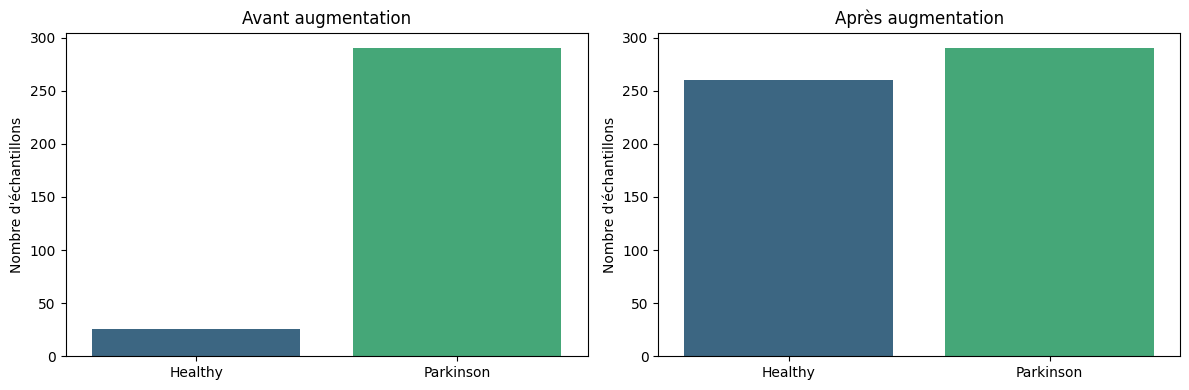

📊 Comparaison des ratios:
   • Avant: 11.2:1
   • Après: 1.1:1
   • Amélioration: 10.0x


In [133]:
# === CELLULE 11: VISUALISATION APRÈS AUGMENTATION ===
def plot_comparison_before_after(y_before, y_after):
    """Comparaison visuelle avant/après augmentation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Avant augmentation
    counts_before = Counter(y_before)
    sns.barplot(x=list(counts_before.keys()), y=list(counts_before.values()), 
                palette="viridis", ax=ax1)
    ax1.set_xticks([0,1])
    ax1.set_xticklabels(["Healthy", "Parkinson"])
    ax1.set_title("Avant augmentation")
    ax1.set_ylabel("Nombre d'échantillons")
    
    # Après augmentation
    counts_after = Counter(y_after)
    sns.barplot(x=list(counts_after.keys()), y=list(counts_after.values()), 
                palette="viridis", ax=ax2)
    ax2.set_xticks([0,1])
    ax2.set_xticklabels(["Healthy", "Parkinson"])
    ax2.set_title("Après augmentation")
    ax2.set_ylabel("Nombre d'échantillons")
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    ratio_before = counts_before[1] / counts_before[0]
    ratio_after = counts_after[1] / counts_after[0]
    print(f"📊 Comparaison des ratios:")
    print(f"   • Avant: {ratio_before:.1f}:1")
    print(f"   • Après: {ratio_after:.1f}:1")
    print(f"   • Amélioration: {ratio_before/ratio_after:.1f}x")

# Visualisation de la comparaison
plot_comparison_before_after(y, y_aug)

In [134]:
# === CELLULE 11: DIVISION STRATIFIÉE DES DONNÉES ===
def create_stratified_splits(X, y, patient_info):
    """Division stratifiée en train/validation/test"""
    print("=== DIVISION STRATIFIÉE DES DONNÉES ===\n")
    
    # Split initial: train + temp vs test
    X_temp, X_test, y_temp, y_test, info_temp, info_test = train_test_split(
        X, y, patient_info, 
        test_size=config.TEST_SIZE, 
        stratify=y, 
        random_state=config.RANDOM_STATE
    )
    
    # Split secondaire: train vs validation
    val_size_adjusted = config.VAL_SIZE / (1 - config.TEST_SIZE)
    X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(
        X_temp, y_temp, info_temp,
        test_size=val_size_adjusted,
        stratify=y_temp,
        random_state=config.RANDOM_STATE
    )
    
    # Affichage des statistiques
    splits = [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
        ("Test", X_test, y_test)
    ]
    
    print("📊 Répartition des splits:")
    for name, X_split, y_split in splits:
        count = len(X_split)
        parkinson_count = sum(y_split)
        healthy_count = len(y_split) - parkinson_count
        parkinson_pct = parkinson_count / count * 100
        healthy_pct = healthy_count / count * 100
        
        print(f"   {name}: {count} échantillons")
        print(f"      Parkinson: {parkinson_count} ({parkinson_pct:.1f}%)")
        print(f"      Healthy: {healthy_count} ({healthy_pct:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, info_train, info_val, info_test

# Exécution de la division
X_train, X_val, X_test, y_train, y_val, y_test, info_train, info_val, info_test = create_stratified_splits(X_aug, y_aug, info_aug)

=== DIVISION STRATIFIÉE DES DONNÉES ===

📊 Répartition des splits:
   Train: 384 échantillons
      Parkinson: 202 (52.6%)
      Healthy: 182 (47.4%)
   Validation: 83 échantillons
      Parkinson: 44 (53.0%)
      Healthy: 39 (47.0%)
   Test: 83 échantillons
      Parkinson: 44 (53.0%)
      Healthy: 39 (47.0%)


=== VISUALISATION DES DONNÉES PRÉTRAITÉES ===



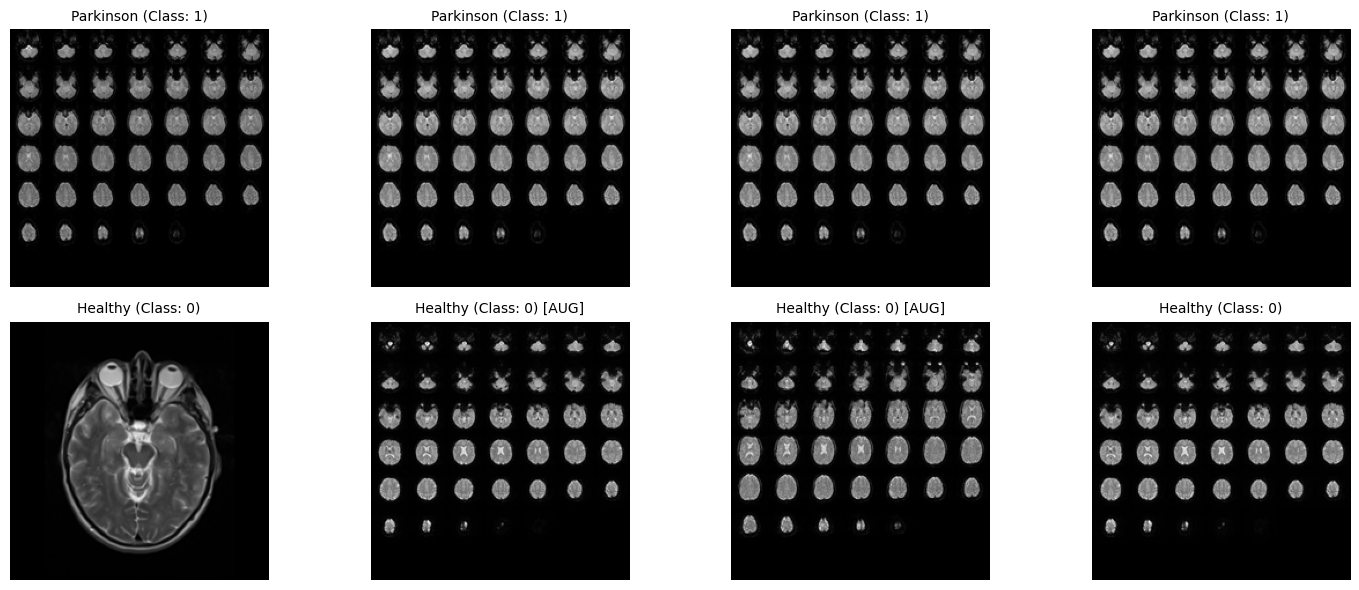

📐 Dimensions dans le training set: {(224, 224, 1): 384}


In [125]:
# === CELLULE 12: VISUALISATION DES DONNÉES PRÉTRAITÉES ===
def visualize_processed_data(X_train, y_train, info_train, n_samples=8):
    """Visualisation des échantillons après prétraitement"""
    print("=== VISUALISATION DES DONNÉES PRÉTRAITÉES ===\n")
    
    # Sélection d'échantillons équilibrés
    parkinson_indices = [i for i, label in enumerate(y_train) if label == 1][:n_samples//2]
    healthy_indices = [i for i, label in enumerate(y_train) if label == 0][:n_samples//2]
    selected_indices = parkinson_indices + healthy_indices
    
    # Création de la figure
    fig, axes = plt.subplots(2, n_samples//2, figsize=(15, 6))
    
    if n_samples//2 == 1:
        axes = [[axes]]
    
    for idx, (ax, sample_idx) in enumerate(zip(axes.flat, selected_indices)):
        img = X_train[sample_idx]
        label = y_train[sample_idx]
        group = info_train[sample_idx]['group']
        augmented = info_train[sample_idx].get('augmented', False)
        
        # Affichage de l'image
        if img.shape[2] == 1:  # Grayscale
            ax.imshow(img[:, :, 0], cmap='gray')
        else:  # RGB
            ax.imshow(img)
        
        # Configuration du titre
        title = f"{group} (Class: {label})"
        if augmented:
            title += " [AUG]"
            ax.set_facecolor('lightyellow')
        
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques de shape
    shapes = Counter([img.shape for img in X_train])
    print(f"📐 Dimensions dans le training set: {dict(shapes)}")

# Exécution de la visualisation
visualize_processed_data(X_train, y_train, info_train)

In [126]:
# === CELLULE 13: SAUVEGARDE DES DONNÉES PRÉTRAITÉES ===
def save_processed_data(X_train, X_val, X_test, y_train, y_val, y_test, 
                       info_train, info_val, info_test, save_path=config.SAVE_PATH):
    """Sauvegarde des données prétraitées"""
    print("=== SAUVEGARDE DES DONNÉES PRÉTRAITÉES ===\n")
    
    # Sauvegarde des arrays numpy
    np.save(os.path.join(save_path, "X_train.npy"), X_train)
    np.save(os.path.join(save_path, "X_val.npy"), X_val)
    np.save(os.path.join(save_path, "X_test.npy"), X_test)
    np.save(os.path.join(save_path, "y_train.npy"), y_train)
    np.save(os.path.join(save_path, "y_val.npy"), y_val)
    np.save(os.path.join(save_path, "y_test.npy"), y_test)
    
    # Sauvegarde des métadonnées
    joblib.dump(info_train, os.path.join(save_path, "info_train.pkl"))
    joblib.dump(info_val, os.path.join(save_path, "info_val.pkl"))
    joblib.dump(info_test, os.path.join(save_path, "info_test.pkl"))
    
    # Sauvegarde des statistiques
    stats = {
        'total_samples': len(X_train) + len(X_val) + len(X_test),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'parkinson_count': sum(y_train) + sum(y_val) + sum(y_test),
        'healthy_count': (len(y_train) + len(y_val) + len(y_test)) - (sum(y_train) + sum(y_val) + sum(y_test)),
        'image_shape': X_train[0].shape,
        'augmentation_applied': any('augmented' in info for info in info_train)
    }
    
    joblib.dump(stats, os.path.join(save_path, "dataset_stats.pkl"))
    
    print(f"✅ Données sauvegardées dans: {save_path}")
    print(f"📁 Fichiers créés:")
    for file in os.listdir(save_path):
        size_kb = os.path.getsize(os.path.join(save_path, file)) // 1024
        print(f"   - {file}: {size_kb} KB")
    
    print(f"\n📊 Statistiques du dataset:")
    for key, value in stats.items():
        print(f"   {key}: {value}")

# Exécution de la sauvegarde
save_processed_data(X_train, X_val, X_test, y_train, y_val, y_test, 
                   info_train, info_val, info_test)

=== SAUVEGARDE DES DONNÉES PRÉTRAITÉES ===

✅ Données sauvegardées dans: /kaggle/working/processed_data/
📁 Fichiers créés:
   - info_val.pkl: 10 KB
   - y_val.npy: 0 KB
   - config.json: 0 KB
   - info_train.pkl: 49 KB
   - y_test.npy: 0 KB
   - X_test.npy: 32536 KB
   - info_test.pkl: 11 KB
   - X_train.npy: 150528 KB
   - y_train.npy: 3 KB
   - dataset_stats.pkl: 0 KB
   - X_val.npy: 32536 KB

📊 Statistiques du dataset:
   total_samples: 550
   train_samples: 384
   val_samples: 83
   test_samples: 83
   parkinson_count: 290
   healthy_count: 260
   image_shape: (224, 224, 1)
   augmentation_applied: True


In [127]:
# === CELLULE 14: VÉRIFICATION FINALE ET RAPPORT ===
def final_verification_report():
    """Rapport final de vérification"""
    print("=== RAPPORT FINAL DE VÉRIFICATION ===\n")
    
    # Chargement des données sauvegardées pour vérification
    X_train = np.load(os.path.join(config.SAVE_PATH, "X_train.npy"), allow_pickle=True)
    X_val = np.load(os.path.join(config.SAVE_PATH, "X_val.npy"), allow_pickle=True)
    X_test = np.load(os.path.join(config.SAVE_PATH, "X_test.npy"), allow_pickle=True)
    y_train = np.load(os.path.join(config.SAVE_PATH, "y_train.npy"), allow_pickle=True)
    y_val = np.load(os.path.join(config.SAVE_PATH, "y_val.npy"), allow_pickle=True)
    y_test = np.load(os.path.join(config.SAVE_PATH, "y_test.npy"), allow_pickle=True)
    
    # Tests de vérification
    verification_tests = {
        "Dimensions cohérentes": len(set(img.shape for img in X_train)) == 1,
        "Normalisation [0,1]": all(0 <= np.min(img) <= 1 and 0 <= np.max(img) <= 1 
                                  for img in X_train[:10]),
        "Absence de NaN/Inf": not any(np.isnan(img).any() or np.isinf(img).any() 
                                     for img in X_train),
        "Classes équilibrées (train)": abs(sum(y_train) - (len(y_train) - sum(y_train))) / len(y_train) < 0.3,
        "Split proportions": (0.6 <= len(X_train)/(len(X_train)+len(X_val)+len(X_test)) <= 0.8 and
                            0.1 <= len(X_val)/(len(X_train)+len(X_val)+len(X_test)) <= 0.2 and
                            0.1 <= len(X_test)/(len(X_train)+len(X_val)+len(X_test)) <= 0.2),
        "Shape cible atteinte": X_train[0].shape == (config.TARGET_SIZE[0], config.TARGET_SIZE[1], 1)
    }
    
    # Affichage des résultats
    passed_tests = sum(verification_tests.values())
    total_tests = len(verification_tests)
    
    print("🧪 Résultats des tests de vérification:")
    for test_name, test_result in verification_tests.items():
        status = "✅" if test_result else "❌"
        print(f"   {status} {test_name}")
    
    print(f"\n🎯 Score final: {passed_tests}/{total_tests}")
    
    if passed_tests == total_tests:
        print("""
✨ EXCELLENT! Le dataset est prêt pour l'entraînement.
Prochaine étape: Extraction de features et modélisation.
        """)
    elif passed_tests >= 4:
        print("""
⚠ ACCEPTABLE! Le dataset peut être utilisé, mais surveillez les points d'alerte.
Prochaine étape: Extraction de features avec monitoring renforcé.
        """)
    else:
        print("""
❌ CRITIQUE! Corrigez les problèmes avant de continuer.
Revoir le prétraitement des données.
        """)
    
    return passed_tests == total_tests

# Exécution de la vérification finale
dataset_ready = final_verification_report()

=== RAPPORT FINAL DE VÉRIFICATION ===

🧪 Résultats des tests de vérification:
   ✅ Dimensions cohérentes
   ✅ Normalisation [0,1]
   ✅ Absence de NaN/Inf
   ✅ Classes équilibrées (train)
   ✅ Split proportions
   ✅ Shape cible atteinte

🎯 Score final: 6/6

✨ EXCELLENT! Le dataset est prêt pour l'entraînement.
Prochaine étape: Extraction de features et modélisation.
        


In [128]:
# === CELLULE 15: RAPPORT DE SYNTHÈSE ===
def generate_summary_report():
    """Génération d'un rapport de synthèse complet"""
    print("=== RAPPORT DE SYNTHÈSE DU PRÉTRAITEMENT ===\n")
    
    # Chargement des statistiques
    stats = joblib.load(os.path.join(config.SAVE_PATH, "dataset_stats.pkl"))
    
    print("📈 STATISTIQUES FINALES:")
    for key, value in stats.items():
        print(f"   {key}: {value}")
    
    print(f"\n🎯 CONFIGURATION APPLIQUÉE:")
    print(f"   Target size: {config.TARGET_SIZE}")
    print(f"   RGB conversion: {config.CONVERT_TO_RGB}")
    print(f"   Test size: {config.TEST_SIZE}")
    print(f"   Validation size: {config.VAL_SIZE}")
    print(f"   Augmentation factor: {config.AUGMENTATION_FACTOR}")

# Génération du rapport
generate_summary_report()

=== RAPPORT DE SYNTHÈSE DU PRÉTRAITEMENT ===

📈 STATISTIQUES FINALES:
   total_samples: 550
   train_samples: 384
   val_samples: 83
   test_samples: 83
   parkinson_count: 290
   healthy_count: 260
   image_shape: (224, 224, 1)
   augmentation_applied: True

🎯 CONFIGURATION APPLIQUÉE:
   Target size: (224, 224)
   RGB conversion: False
   Test size: 0.15
   Validation size: 0.15
   Augmentation factor: 2


## Prochaine étape : EXTRACTION DE FEATURES & MODÉLISATION